In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown
import kagglehub
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

# Helper Functions

In [2]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

def add_events(events_timestamps, is_repeat=False):
    dummy_date = '2017-04-10'
    events = pd.DatetimeIndex([dummy_date])
    if is_repeat:
        for i in range(len([2018,2019,2020,2021,2022,2023,2024,2025,2026])):
            events = events.append(pd.date_range(start=events_timestamps[0], end=events_timestamps[1]) \
                                   + pd.tseries.offsets.DateOffset(months=i*12))
    else:
        for event in events_timestamps:
            events = events.append(pd.date_range(start=event[0], end=event[1]))
    return events[1:]

def assign_historic_sales(df, year_till=2022):
    df = df.reset_index()
    sales = df[['Order Date', 'total_sales']]
    sales = sales.set_index('Order Date')
    past_sales = list(sales[sales.index.year <= year_till]['total_sales'])
    lag = [np.nan] * (len(sales) - len(past_sales))
    lag.extend(past_sales)
    lag = pd.Series(lag, index=sales.index)
    df = df.set_index('Order Date')
    return lag

def add_amazon_events(df):
    global amazon_events_df
    df = pd.merge(df, amazon_events_df, left_index=True, right_index=True, how='left')
    df['Amazon Events'] = df['Amazon Events'].fillna('No Events')
    df = pd.get_dummies(df, drop_first=True)
    return df

# Dataset imports

In [3]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")
purchases = pd.read_csv(path)
purchases = purchases[purchases['Shipping Address State'].notnull()]
purchases.rename(columns={'ASIN/ISBN (Product Code)': 'product_code'}, inplace=True)

path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays.set_index('Date', inplace=True)

path = fetch_dataset("19167R4OV0GWNiCHTh3w9T07616S91enj", "amazon_categories.csv")
categories = pd.read_csv(path)

path = fetch_dataset("1yoaKl-7wctxH315gH_M15fS5WERnFlHe", "amazon_products.csv")
products = pd.read_csv(path)
products = products.rename(columns={'asin':'product_code'})

amazon_purchases.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_purchases.csv
amazon_categories.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_categories.csv
amazon_products.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_products.csv


## Data Cleaning

In [4]:
products = pd.merge(products, categories, how='inner', left_on='category_id', right_on='id').drop('id', axis=1)
product_codes_category_null = purchases[purchases['Category'].isnull()]['product_code']

data_replacements = products[products['product_code'].isin(product_codes_category_null.unique())][['product_code','title','category_name']]

purchases = pd.merge(purchases, data_replacements, on='product_code', how='left')

purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'Category'] = purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'category_name']

purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'Title'] = purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'title']
purchases.drop(['title', 'category_name'], axis=1, inplace=True)
purchases.dropna(axis=0,subset= ['Shipping Address State','Category'], inplace=True)

In [5]:
get_null_percentage(purchases)

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Shipping Address State     0.000000
Survey ResponseID          0.000000
Category                   0.000000
product_code               0.016695
Title                      0.033391
dtype: float64

In [6]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF
5,2019-02-18,10.99,1.0,NJ,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,COMPUTER_PROCESSOR,R_01vNIayewjIIKMF
...,...,...,...,...,...,...,...,...
1762900,2021-04-01,20.75,1.0,MA,50 Feather (Yellow Label) Razor Blades Platinu...,B08P5K9GMJ,RAZOR_BLADE_CARTRIDGE,R_zfqnsBzlOAKibzb
1762901,2021-04-01,6.99,1.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1762902,2021-04-14,15.99,1.0,MA,Sinland Microfiber Cleaning Cloth Dish Cloth K...,B00QGCXPRG,TOWEL,R_zfqnsBzlOAKibzb
1762903,2021-05-22,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb


# Feature engineering

In [7]:
# Best Average sales
ma_purchases = purchases.copy()
ma_purchases['Order Date'] = pd.to_datetime(ma_purchases['Order Date'])
ma_purchases.set_index('Order Date', inplace=True)
ma_purchases = ma_purchases[(ma_purchases.index.year<2023) & (ma_purchases['Shipping Address State']== 'MA')]
ma_purchases.loc[:,'total_sales'] = ma_purchases['Purchase Price Per Unit'] * ma_purchases['Quantity']

# Best Performing
ca_purchases = purchases.copy()
ca_purchases['Order Date'] = pd.to_datetime(ca_purchases['Order Date'])
ca_purchases.set_index('Order Date', inplace=True)
ca_purchases = ca_purchases[(ca_purchases.index.year<2023) & (ca_purchases['Shipping Address State']== 'CA')]
ca_purchases.loc[:,'total_sales'] = ca_purchases['Purchase Price Per Unit'] * ca_purchases['Quantity']

# Least performing
ga_purchases = purchases.copy()
ga_purchases['Order Date'] = pd.to_datetime(ga_purchases['Order Date'])
ga_purchases.set_index('Order Date', inplace=True)
ga_purchases = ga_purchases[(ga_purchases.index.year<2023) & (ga_purchases['Shipping Address State']== 'GA')]
ga_purchases.loc[:,'total_sales'] = ga_purchases['Purchase Price Per Unit'] * ga_purchases['Quantity']


In [8]:
ma_df = ma_purchases.copy()
ma_df = pd.DataFrame(ma_df.groupby(ma_df.index)['total_sales'].sum())

ca_df = ca_purchases.copy()
ca_df = pd.DataFrame(ca_df.groupby(ca_df.index)['total_sales'].sum())

ga_df = ga_purchases.copy()
ga_df = pd.DataFrame(ga_df.groupby(ga_df.index)['total_sales'].sum())


**Add time features**

In [9]:
ma_df = generate_time_features(ma_df)
ca_df = generate_time_features(ca_df)
ga_df = generate_time_features(ga_df)

In [10]:
ma_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end
Order Date,,,,,,,,,,,,
2018-01-01,322.36,1,1,2018,False,0,1,1,True,False,True,False
2018-01-02,375.45,2,1,2018,False,1,2,1,False,False,False,False
2018-01-03,297.77,3,1,2018,False,2,3,1,False,False,False,False
2018-01-04,330.45,4,1,2018,False,3,4,1,False,False,False,False
2018-01-05,672.18,5,1,2018,False,4,5,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,251.55,27,12,2022,False,1,361,4,False,False,False,False
2022-12-28,962.12,28,12,2022,False,2,362,4,False,False,False,False
2022-12-29,292.19,29,12,2022,False,3,363,4,False,False,False,False


In [11]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end
Order Date,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,True,False
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,False,False
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,False,False
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,False,False
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,False,False
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,False,False
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,False,False


In [12]:
ga_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end
Order Date,,,,,,,,,,,,
2018-01-01,120.85,1,1,2018,False,0,1,1,True,False,True,False
2018-01-02,223.69,2,1,2018,False,1,2,1,False,False,False,False
2018-01-03,750.11,3,1,2018,False,2,3,1,False,False,False,False
2018-01-04,188.71,4,1,2018,False,3,4,1,False,False,False,False
2018-01-05,296.01,5,1,2018,False,4,5,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,522.93,27,12,2022,False,1,361,4,False,False,False,False
2022-12-28,716.57,28,12,2022,False,2,362,4,False,False,False,False
2022-12-29,313.63,29,12,2022,False,3,363,4,False,False,False,False


**Add amazon events**

In [13]:
amazon_events = add_events([['2024-03-20', '2024-03-25'], ['2025-03-25', '2025-03-31']])
spring_sale_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Big Spring Sale']*len(amazon_events)}).set_index('Event Date')

In [14]:
amazon_events = add_events([
    ['2018-07-16', '2018-07-17'],
    ['2019-07-15', '2019-07-16'],
    ['2020-10-13', '2020-10-14'],
    ['2021-06-21', '2021-06-22'],
    ['2022-07-12', '2022-07-13'],
    ['2023-07-11', '2023-07-12'],
    ['2024-07-16', '2024-07-17'],
    ['2025-07-23', '2025-07-24']
])
prime_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Amazon Prime Day']*len(amazon_events)}).set_index('Event Date')

In [15]:
amazon_events = add_events([
    ['2022-10-11', '2022-10-12'],  
    ['2023-10-10', '2023-10-11'],  
    ['2024-10-08', '2024-10-09'],
    ['2025-10-14', '2025-10-15']
])
prime_big_deal_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Prime Big Deal Days']*len(amazon_events)}).set_index('Event Date')

In [16]:
amazon_events = add_events([
    ['2018-11-16', '2018-11-23'],
    ['2019-11-22', '2019-11-29'],
    ['2020-11-20', '2020-11-27'],
    ['2021-11-19', '2021-11-26'],
    ['2022-11-24', '2022-11-25'],
    ['2023-11-17', '2023-11-24'],
    ['2024-11-21', '2024-11-29'],
    ['2025-11-28', '2025-12-01']
]
)
black_friday_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Black Friday']*len(amazon_events)}).set_index('Event Date')

In [17]:
amazon_events = add_events([
    ['2018-02-05', '2018-02-14'],
    ['2019-02-04', '2019-02-14'],
    ['2020-02-03', '2020-02-14'],
    ['2021-02-01', '2021-02-14'],
    ['2022-02-03', '2022-02-10'],
    ['2023-02-04', '2023-02-14'],
    ['2024-02-02', '2024-02-14'],
    ['2025-02-02', '2025-02-14']
])
valentines_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Valentine's Day Promotions"]*len(amazon_events)}).set_index('Event Date')

In [18]:
amazon_events = add_events([
    ['2018-05-01', '2018-05-13'],
    ['2019-05-03', '2019-05-12'],
    ['2020-05-01', '2020-05-10'],
    ['2021-05-01', '2021-05-09'],
    ['2022-05-03', '2022-05-09'],
    ['2023-05-01', '2023-05-14'],
    ['2024-05-02', '2024-05-12'],
    ['2025-05-06', '2025-05-12']
])
mothers_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Mother's Day Deals"]*len(amazon_events)}).set_index('Event Date')

In [19]:
amazon_events = add_events([
    ['2018-05-25', '2018-05-28'],
    ['2019-05-24', '2019-05-27'],
    ['2020-05-22', '2020-05-25'],
    ['2021-05-28', '2021-05-31'],
    ['2022-05-27', '2022-05-30'],
    ['2023-05-26', '2023-05-29'],
    ['2024-05-24', '2024-05-27'],
    ['2025-05-23', '2025-05-26']
])
memorial_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Memorial Day Sales"]*len(amazon_events)}).set_index('Event Date')

In [20]:
amazon_events = add_events(('2018-12-02', '2018-12-13'), is_repeat=True)
_12_day_of_deals_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['12 Days of Deals']*len(amazon_events)}).set_index('Event Date')

In [21]:
amazon_events = add_events(('2018-12-25', '2019-01-01'), is_repeat=True)
year_end_clearance_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Year-End Clearance Sale']*len(amazon_events)}).set_index('Event Date')

**concat**

In [22]:
amazon_events_df = pd.concat([spring_sale_event_df,prime_day_event_df,prime_big_deal_event_df,black_friday_event_df,valentines_day_event_df,mothers_day_event_df,memorial_day_event_df,_12_day_of_deals_event_df,year_end_clearance_event_df], axis=0).sort_index()

In [23]:
amazon_events_df

,Amazon Events
Event Date,
2018-02-05,Valentine's Day Promotions
2018-02-06,Valentine's Day Promotions
2018-02-07,Valentine's Day Promotions
2018-02-08,Valentine's Day Promotions
2018-02-09,Valentine's Day Promotions
...,...
2026-12-28,Year-End Clearance Sale
2026-12-29,Year-End Clearance Sale
2026-12-30,Year-End Clearance Sale


Text(0.5, 0, 'Amazon events in 2018')

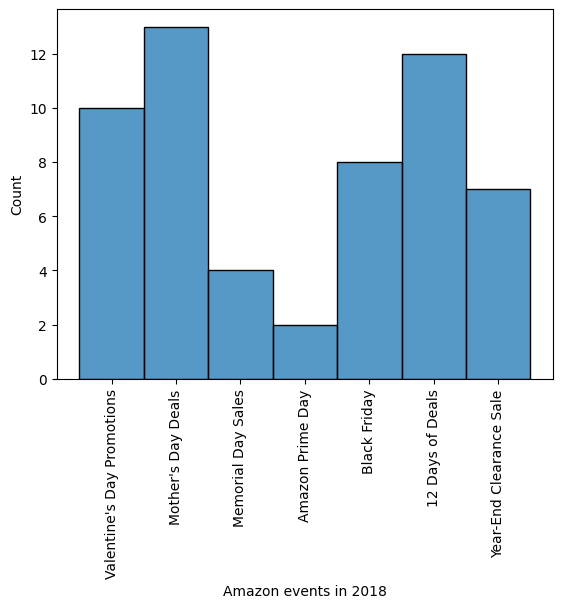

In [24]:
sns.histplot(amazon_events_df[amazon_events_df.index.year==2018], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2018')

Text(0.5, 0, 'Amazon events yearly')

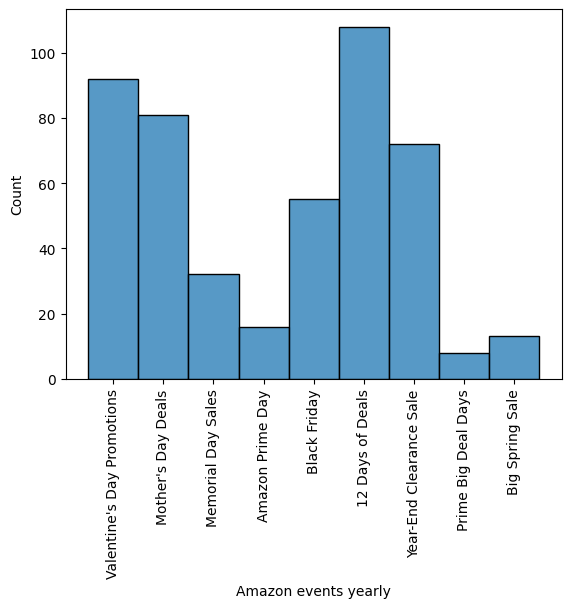

In [25]:
sns.histplot(amazon_events_df, x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events yearly')

In [26]:
ma_df = pd.merge(ma_df, amazon_events_df, left_index=True, right_index=True, how='left')
ca_df = pd.merge(ca_df, amazon_events_df, left_index=True, right_index=True, how='left')
ga_df = pd.merge(ga_df, amazon_events_df, left_index=True, right_index=True, how='left')

In [27]:
ma_df['Amazon Events'] = ma_df['Amazon Events'].fillna('No Events')
ca_df['Amazon Events'] = ca_df['Amazon Events'].fillna('No Events')
ga_df['Amazon Events'] = ga_df['Amazon Events'].fillna('No Events')

Text(0.5, 0, 'Amazon events in 2022')

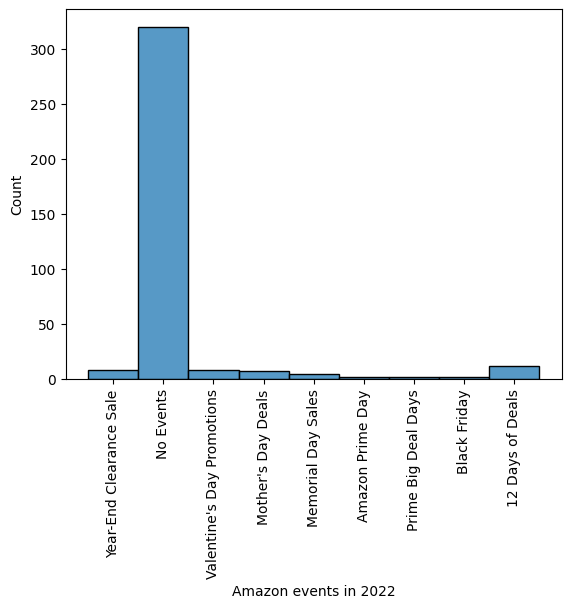

In [28]:
sns.histplot(ma_df[ma_df.index.year==2022], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2022')

In [29]:
ma_df = pd.get_dummies(ma_df, drop_first=True)
ca_df = pd.get_dummies(ca_df, drop_first=True)
ga_df = pd.get_dummies(ga_df, drop_first=True)

In [30]:
ma_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale
Order Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,322.36,1,1,2018,False,0,1,1,True,False,True,False,False,False,False,False,True,False,False,False
2018-01-02,375.45,2,1,2018,False,1,2,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-03,297.77,3,1,2018,False,2,3,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-04,330.45,4,1,2018,False,3,4,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-05,672.18,5,1,2018,False,4,5,1,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,251.55,27,12,2022,False,1,361,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-28,962.12,28,12,2022,False,2,362,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-29,292.19,29,12,2022,False,3,363,4,False,False,False,False,False,False,False,False,False,False,False,True


In [31]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale
Order Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,True,False,False,False,False,False,True,False,False,False
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,False,False,False,False,False,False,False,False,False,True


In [32]:
ga_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale
Order Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,120.85,1,1,2018,False,0,1,1,True,False,True,False,False,False,False,False,True,False,False,False
2018-01-02,223.69,2,1,2018,False,1,2,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-03,750.11,3,1,2018,False,2,3,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-04,188.71,4,1,2018,False,3,4,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-05,296.01,5,1,2018,False,4,5,1,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,522.93,27,12,2022,False,1,361,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-28,716.57,28,12,2022,False,2,362,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-29,313.63,29,12,2022,False,3,363,4,False,False,False,False,False,False,False,False,False,False,False,True


**Add holidays**

In [33]:
ma_df = pd.merge(ma_df, holidays['is_holiday'], how='left', left_index=True, right_index=True)
ma_df = add_holidays_past_2021(ma_df)
ma_df['fedral_holiday'] = ma_df['is_holiday'].fillna(False) + ma_df['fedral_holiday'].fillna(False)
ma_df.drop('is_holiday', axis=1, inplace=True)

ca_df = pd.merge(ca_df, holidays['is_holiday'], how='left', left_index=True, right_index=True)
ca_df = add_holidays_past_2021(ca_df)
ca_df['fedral_holiday'] = ca_df['is_holiday'].fillna(False) + ca_df['fedral_holiday'].fillna(False)
ca_df.drop('is_holiday', axis=1, inplace=True)

ga_df = pd.merge(ga_df, holidays['is_holiday'], how='left', left_index=True, right_index=True)
ga_df = add_holidays_past_2021(ga_df)
ga_df['fedral_holiday'] = ga_df['is_holiday'].fillna(False) + ga_df['fedral_holiday'].fillna(False)
ga_df.drop('is_holiday', axis=1, inplace=True)

C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\1299803848.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ma_df['fedral_holiday'] = ma_df['is_holiday'].fillna(False) + ma_df['fedral_holiday'].fillna(False)
C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\1299803848.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ca_df['fedral_holiday'] = ca_df['is_holiday'].fillna(False) + ca_df['fedral_holiday'].fillna(False)
C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\1299803848.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill,

In [34]:
df['fedral_holiday'].value_counts()

NameError: name 'df' is not defined

**Add inflation**

**Add historic overall sales**

In [35]:
ma_df['Sales 1YA'] = assign_historic_sales(ma_df, year_till=2021)
ma_df['Sales 2YA'] = assign_historic_sales(ma_df, year_till=2020)
ma_df['Sales 3YA'] = assign_historic_sales(ma_df, year_till=2019)

ca_df['Sales 1YA'] = assign_historic_sales(ca_df, year_till=2021)
ca_df['Sales 2YA'] = assign_historic_sales(ca_df, year_till=2020)
ca_df['Sales 3YA'] = assign_historic_sales(ca_df, year_till=2019)

ga_df['Sales 1YA'] = assign_historic_sales(ga_df, year_till=2021)
ga_df['Sales 2YA'] = assign_historic_sales(ga_df, year_till=2020)
ga_df['Sales 3YA'] = assign_historic_sales(ga_df, year_till=2019)

In [36]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,fedral_holiday,Sales 1YA,Sales 2YA,Sales 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,...,False,False,True,False,False,False,True,NaN,NaN,NaN
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,...,False,False,False,False,False,True,False,2499.66,2883.14,1779.99
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,...,False,False,False,False,False,True,False,3295.22,2891.85,1661.71
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,...,False,False,False,False,False,True,False,2317.13,3035.74,1603.16


**Add historic state-wise sales**

In [37]:
def get_shift_value(year, df, forcast_df=None):
    if forcast_df is None:
        return (df[df.index.year<2023].index[-1] - df[df.index.year<=year].index[-1]).days
    else:
        return (forcast_df.index[-1] - df[df.index.year<=year].index[-1]).days

In [38]:
def add_category_lags(purchases, df):
    temp_df = purchases[['Category','total_sales']]
    
    temp_df = pd.DataFrame(temp_df.groupby([temp_df.index,'Category'])['total_sales'].sum()).reset_index()
    
    category_features = pd.pivot( temp_df[['Order Date', 'Category', 'total_sales']], index='Order Date', columns='Category', values='total_sales').reset_index().fillna(0)
    
    category_features = category_features.set_index('Order Date')

    scaler = MinMaxScaler()

    scaled_data = scaler.fit_transform(category_features)
    
    pca = PCA(n_components=3,random_state=101)
    
    pca_features = pca.fit_transform(scaled_data)

    category_sales_reduced = pd.DataFrame(pca_features)

    category_sales_reduced.rename(columns={0:'PC1',1:'PC2',2:'PC3'}, inplace=True)

    category_sales_reduced.set_index(df.index, inplace=True)

    category_features = pd.concat([category_sales_reduced, category_sales_reduced.shift(get_shift_value(2021,df)).rename(columns={'PC1':'PC1 1YA','PC2':'PC2 1YA','PC3':'PC3 1YA'}), category_sales_reduced.shift(get_shift_value(2020,df)).rename(columns={'PC1':'PC1 2YA','PC2':'PC2 2YA','PC3':'PC3 2YA'}), category_sales_reduced.shift(get_shift_value(2019,df)).rename(columns={'PC1':'PC1 3YA','PC2':'PC2 3YA','PC3':'PC3 3YA'})], axis=1)

    return pd.merge(df, category_features, left_index=True, right_index=True, how='left')

In [39]:
ca_df = add_category_lags(ca_purchases.copy(), ca_df.copy())
ma_df = add_category_lags(ma_purchases.copy(), ma_df.copy())
ga_df = add_category_lags(ga_purchases.copy(), ga_df.copy())

In [40]:
get_null_percentage(ca_df)

total_sales                                  0.000000
day                                          0.000000
month                                        0.000000
year                                         0.000000
is_weekend                                   0.000000
day_of_week                                  0.000000
day_of_year                                  0.000000
quarter                                      0.000000
is_month_start                               0.000000
is_month_end                                 0.000000
is_year_start                                0.000000
is_year_end                                  0.000000
Amazon Events_Amazon Prime Day               0.000000
Amazon Events_Black Friday                   0.000000
Amazon Events_Memorial Day Sales             0.000000
Amazon Events_Mother's Day Deals             0.000000
Amazon Events_No Events                      0.000000
Amazon Events_Prime Big Deal Days            0.000000
Amazon Events_Valentine's Da

## Cross Validation

**generate forcast dataframe**

In [41]:
feature_columns = list(ca_df.columns)
[feature_columns.remove(column) for column in ['total_sales','PC1','PC2','PC3']]
feature_columns

['day',
 'month',
 'year',
 'is_weekend',
 'day_of_week',
 'day_of_year',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_year_start',
 'is_year_end',
 'Amazon Events_Amazon Prime Day',
 'Amazon Events_Black Friday',
 'Amazon Events_Memorial Day Sales',
 "Amazon Events_Mother's Day Deals",
 'Amazon Events_No Events',
 'Amazon Events_Prime Big Deal Days',
 "Amazon Events_Valentine's Day Promotions",
 'Amazon Events_Year-End Clearance Sale',
 'fedral_holiday',
 'Sales 1YA',
 'Sales 2YA',
 'Sales 3YA',
 'PC1 1YA',
 'PC2 1YA',
 'PC3 1YA',
 'PC1 2YA',
 'PC2 2YA',
 'PC3 2YA',
 'PC1 3YA',
 'PC2 3YA',
 'PC3 3YA']

In [42]:
ca_forcast_df =  pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'),columns=['Order Date'])
ma_forcast_df =  pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'),columns=['Order Date'])
ga_forcast_df =  pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'),columns=['Order Date'])

In [43]:
ca_forcast_df = generate_time_features(ca_forcast_df)
ma_forcast_df = generate_time_features(ma_forcast_df)
ga_forcast_df = generate_time_features(ga_forcast_df)


In [44]:
ca_forcast_df = add_holidays_past_2021(ca_forcast_df)
ma_forcast_df = add_holidays_past_2021(ma_forcast_df)
ga_forcast_df = add_holidays_past_2021(ga_forcast_df)

In [45]:
ca_forcast_df['fedral_holiday'] = ca_forcast_df['fedral_holiday'].fillna(False)
ma_forcast_df['fedral_holiday'] = ma_forcast_df['fedral_holiday'].fillna(False)
ga_forcast_df['fedral_holiday'] = ga_forcast_df['fedral_holiday'].fillna(False)


C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\2435608788.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ca_forcast_df['fedral_holiday'] = ca_forcast_df['fedral_holiday'].fillna(False)
C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\2435608788.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ma_forcast_df['fedral_holiday'] = ma_forcast_df['fedral_holiday'].fillna(False)
C:\Users\rohit\AppData\Local\Temp\ipykernel_22784\2435608788.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in 

In [46]:
ca_forcast_df = add_amazon_events(ca_forcast_df)
ma_forcast_df = add_amazon_events(ma_forcast_df)
ga_forcast_df = add_amazon_events(ga_forcast_df)

In [47]:
ca_forcast_df = ca_forcast_df.drop('index', axis=1)
ma_forcast_df = ma_forcast_df.drop('index', axis=1)
ga_forcast_df = ga_forcast_df.drop('index', axis=1)

In [48]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,PC3,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,...,-0.065581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,...,-0.007399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,...,-0.051748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,...,0.040292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,...,-0.060756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,...,-0.045194,0.089593,-0.079799,0.009743,0.037421,-0.122793,0.154869,0.002903,-0.046140,0.002251
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,...,-0.011386,0.147369,0.339498,0.092591,0.254677,0.272878,0.030991,-0.155592,-0.035450,0.062170
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,...,-0.021207,0.202109,0.172627,0.101446,0.209990,-0.080612,0.090700,-0.074762,-0.072250,0.007765


In [49]:
# Add forecasting flag
ca_forcast_df['forcasting'] = True
ma_forcast_df['forcasting'] = True
ga_forcast_df['forcasting'] = True

ca_df['forcasting'] = False
ma_df['forcasting'] = False
ga_df['forcasting'] = False

# Combine historical + forecast
ca_combined_df = pd.concat([ca_df, ca_forcast_df], axis=0)
ma_combined_df = pd.concat([ma_df, ma_forcast_df], axis=0)
ga_combined_df = pd.concat([ga_df, ga_forcast_df], axis=0)

# Assign sales history
ca_combined_df['Sales 1YA'] = assign_historic_sales(ca_combined_df, year_till=2022)
ca_combined_df['Sales 2YA'] = assign_historic_sales(ca_combined_df, year_till=2021)
ca_combined_df['Sales 3YA'] = assign_historic_sales(ca_combined_df, year_till=2020)

ma_combined_df['Sales 1YA'] = assign_historic_sales(ma_combined_df, year_till=2022)
ma_combined_df['Sales 2YA'] = assign_historic_sales(ma_combined_df, year_till=2021)
ma_combined_df['Sales 3YA'] = assign_historic_sales(ma_combined_df, year_till=2020)

ga_combined_df['Sales 1YA'] = assign_historic_sales(ga_combined_df, year_till=2022)
ga_combined_df['Sales 2YA'] = assign_historic_sales(ga_combined_df, year_till=2021)
ga_combined_df['Sales 3YA'] = assign_historic_sales(ga_combined_df, year_till=2020)

# Lag PC columns
ca_combined_df[['PC1 1YA','PC2 1YA','PC3 1YA']] = ca_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2022, ca_df, ca_forcast_df)-10)
ca_combined_df[['PC1 2YA','PC2 2YA','PC3 2YA']] = ca_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2021,  ca_df, ca_forcast_df)-10)
ca_combined_df[['PC1 3YA','PC2 3YA','PC3 3YA']] = ca_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2020,  ca_df, ca_forcast_df)-10)

ma_combined_df[['PC1 1YA','PC2 1YA','PC3 1YA']] = ma_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2022, ma_df, ma_forcast_df)-10)
ma_combined_df[['PC1 2YA','PC2 2YA','PC3 2YA']] = ma_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2021, ma_df, ma_forcast_df)-10)
ma_combined_df[['PC1 3YA','PC2 3YA','PC3 3YA']] = ma_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2020, ma_df, ma_forcast_df)-10)

ga_combined_df[['PC1 1YA','PC2 1YA','PC3 1YA']] = ga_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2022, ga_df, ga_forcast_df)-10)
ga_combined_df[['PC1 2YA','PC2 2YA','PC3 2YA']] = ga_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2021, ga_df, ga_forcast_df)-10)
ga_combined_df[['PC1 3YA','PC2 3YA','PC3 3YA']] = ga_combined_df[['PC1','PC2','PC3']].shift(get_shift_value(2020, ga_df, ga_forcast_df)-10)

# Assign forecast data back
forecast_cols = ['Sales 1YA', 'Sales 2YA', 'Sales 3YA',
                 'PC1 1YA','PC2 1YA','PC3 1YA',
                 'PC1 2YA','PC2 2YA','PC3 2YA',
                 'PC1 3YA','PC2 3YA','PC3 3YA']

ca_forcast_df[forecast_cols] = ca_combined_df[ca_combined_df['forcasting'] == True][forecast_cols].values
ma_forcast_df[forecast_cols] = ma_combined_df[ma_combined_df['forcasting'] == True][forecast_cols].values
ga_forcast_df[forecast_cols] = ga_combined_df[ga_combined_df['forcasting'] == True][forecast_cols].values

# Drop flag
ca_forcast_df = ca_forcast_df.drop('forcasting', axis=1)
ma_forcast_df = ma_forcast_df.drop('forcasting', axis=1)
ga_forcast_df = ga_forcast_df.drop('forcasting', axis=1)

ca_df = ca_df.drop('forcasting', axis=1)
ma_df = ma_df.drop('forcasting', axis=1)
ga_df = ga_df.drop('forcasting', axis=1)

In [50]:
ca_forcast_df = ca_forcast_df[feature_columns]
ma_forcast_df = ma_forcast_df[feature_columns]
ga_forcast_df = ga_forcast_df[feature_columns]

In [51]:
ca_forcast_df

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1,1,2023,True,6,1,1,True,False,True,...,2688.41,-0.105176,-0.007257,0.011129,-0.033283,0.085444,0.023546,-0.090643,0.149654,-0.057485
2023-01-02,2,1,2023,False,0,2,1,False,False,False,...,2239.30,0.094978,0.119305,0.070811,0.024386,-0.035400,0.070328,-0.232275,-0.074538,0.008150
2023-01-03,3,1,2023,False,1,3,1,False,False,False,...,1727.67,0.187456,0.014040,-0.020315,0.128985,-0.089676,0.014714,-0.107966,-0.130035,-0.073201
2023-01-04,4,1,2023,False,2,4,1,False,False,False,...,2422.77,-0.049206,0.028003,-0.148841,0.235749,0.078987,-0.069394,-0.191607,-0.093524,-0.052243
2023-01-05,5,1,2023,False,3,5,1,False,False,False,...,1026.17,0.103064,-0.087345,0.121954,0.065011,0.006317,-0.010026,-0.080150,-0.075757,0.012610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,27,12,2023,False,2,361,4,False,False,False,...,2883.14,NaN,NaN,NaN,0.142541,0.015081,-0.076156,0.137622,0.024886,0.222053
2023-12-28,28,12,2023,False,3,362,4,False,False,False,...,2891.85,NaN,NaN,NaN,-0.044509,-0.030873,0.080679,0.354607,-0.024591,0.097479
2023-12-29,29,12,2023,False,4,363,4,False,False,False,...,3035.74,NaN,NaN,NaN,0.443783,0.132661,0.191330,0.015815,-0.147660,-0.064698


In [52]:
ca_df[feature_columns]

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,2018,False,0,1,1,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,2,1,2018,False,1,2,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,3,1,2018,False,2,3,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,4,1,2018,False,3,4,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,5,1,2018,False,4,5,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,27,12,2022,False,1,361,4,False,False,False,...,1779.99,0.089593,-0.079799,0.009743,0.037421,-0.122793,0.154869,0.002903,-0.046140,0.002251
2022-12-28,28,12,2022,False,2,362,4,False,False,False,...,1661.71,0.147369,0.339498,0.092591,0.254677,0.272878,0.030991,-0.155592,-0.035450,0.062170
2022-12-29,29,12,2022,False,3,363,4,False,False,False,...,1603.16,0.202109,0.172627,0.101446,0.209990,-0.080612,0.090700,-0.074762,-0.072250,0.007765


**cross validate**

In [70]:

def cross_validate(df, forcastdf, feature_columns):
    scores = []
    preds = []
    feature_importances = []
    sales = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
        reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
        feature_importances.append(reg_model.feature_importances_)
        y_preds = reg_model.predict(X_train)
        score = np.sqrt(mean_squared_error(y_train, y_preds))
        print('train: ',score)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        
        preds.append(y_preds)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        print('test: ',score)
        scores.append(score)

    return preds, scores, feature_importances

[0]	validation_0-rmse:459.99162	validation_1-rmse:740.33803
[1]	validation_0-rmse:440.43505	validation_1-rmse:705.26665
[2]	validation_0-rmse:423.15107	validation_1-rmse:674.23628
[3]	validation_0-rmse:407.86230	validation_1-rmse:646.78285
[4]	validation_0-rmse:394.40803	validation_1-rmse:622.56990
[5]	validation_0-rmse:382.59069	validation_1-rmse:601.15847
[6]	validation_0-rmse:372.14817	validation_1-rmse:582.04271
[7]	validation_0-rmse:363.07915	validation_1-rmse:565.24717
[8]	validation_0-rmse:355.13677	validation_1-rmse:550.41047
[9]	validation_0-rmse:348.23501	validation_1-rmse:537.31420
[10]	validation_0-rmse:342.21714	validation_1-rmse:525.71046
[11]	validation_0-rmse:337.00435	validation_1-rmse:515.45232
[12]	validation_0-rmse:332.47458	validation_1-rmse:506.35911
[13]	validation_0-rmse:328.54434	validation_1-rmse:498.33168
[14]	validation_0-rmse:325.12850	validation_1-rmse:491.16538
[15]	validation_0-rmse:322.16946	validation_1-rmse:484.81775
[16]	validation_0-rmse:319.60153	v

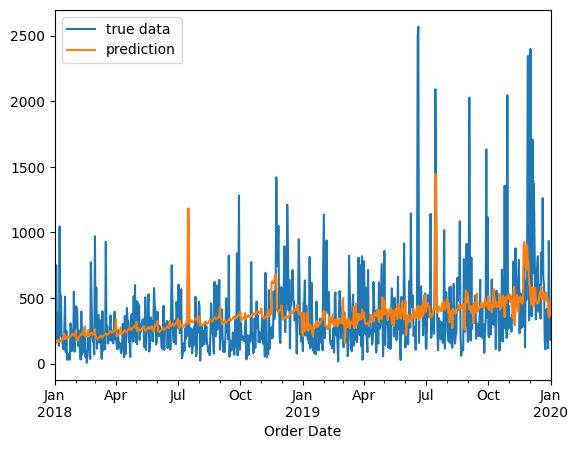

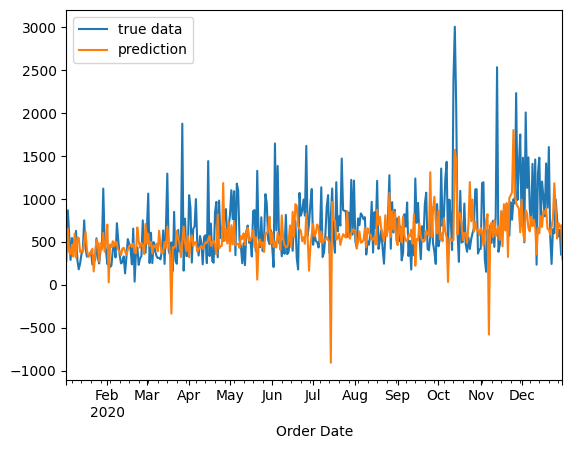

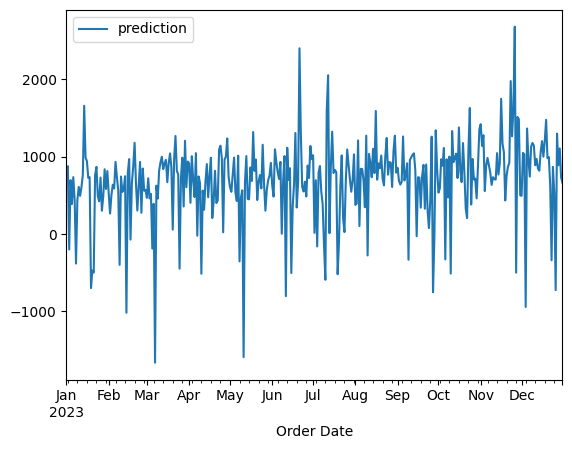

test:  412.0967969053911
[0]	validation_0-rmse:564.95960	validation_1-rmse:1044.99913
[1]	validation_0-rmse:535.70302	validation_1-rmse:1007.12994
[2]	validation_0-rmse:509.82560	validation_1-rmse:972.89592
[3]	validation_0-rmse:486.97169	validation_1-rmse:941.75294
[4]	validation_0-rmse:466.89269	validation_1-rmse:913.62373
[5]	validation_0-rmse:449.31999	validation_1-rmse:888.27288
[6]	validation_0-rmse:433.97607	validation_1-rmse:865.37824
[7]	validation_0-rmse:420.61152	validation_1-rmse:844.64349
[8]	validation_0-rmse:408.99123	validation_1-rmse:825.87221
[9]	validation_0-rmse:398.91802	validation_1-rmse:808.81877
[10]	validation_0-rmse:390.18796	validation_1-rmse:793.36129
[11]	validation_0-rmse:382.64050	validation_1-rmse:779.28771
[12]	validation_0-rmse:376.12701	validation_1-rmse:766.54913
[13]	validation_0-rmse:370.51126	validation_1-rmse:754.98630
[14]	validation_0-rmse:365.65754	validation_1-rmse:744.45369
[15]	validation_0-rmse:361.46722	validation_1-rmse:734.87048
[16]	va

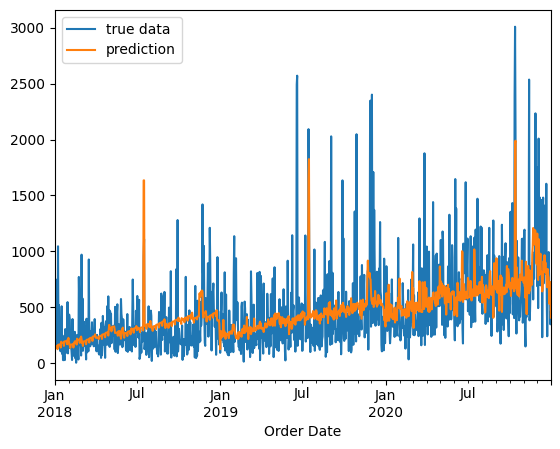

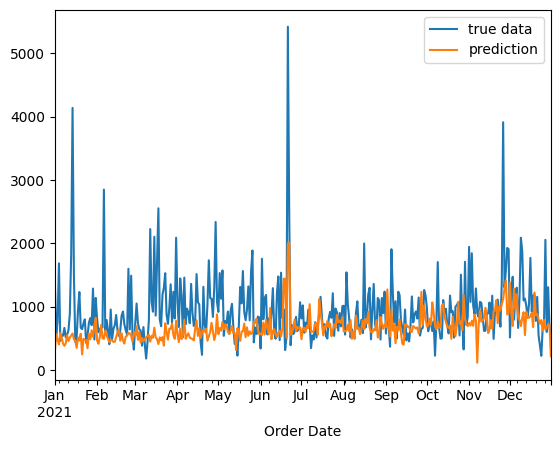

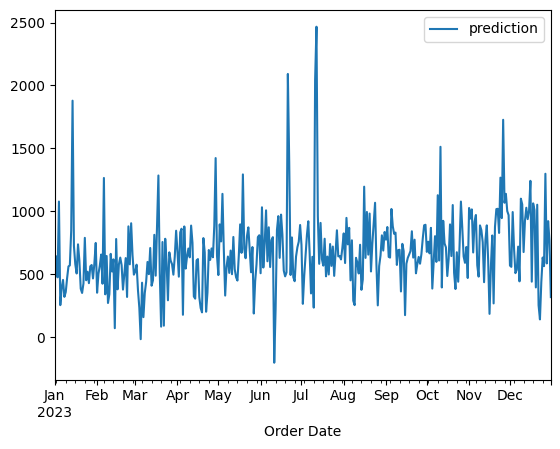

test:  586.1570852683318
[0]	validation_0-rmse:705.67143	validation_1-rmse:847.45248
[1]	validation_0-rmse:666.02848	validation_1-rmse:794.37932
[2]	validation_0-rmse:631.05687	validation_1-rmse:747.33321
[3]	validation_0-rmse:600.28691	validation_1-rmse:705.80626
[4]	validation_0-rmse:573.32238	validation_1-rmse:669.42489
[5]	validation_0-rmse:549.79563	validation_1-rmse:637.63394
[6]	validation_0-rmse:529.28794	validation_1-rmse:609.91025
[7]	validation_0-rmse:511.46956	validation_1-rmse:586.12866
[8]	validation_0-rmse:496.05097	validation_1-rmse:565.62638
[9]	validation_0-rmse:482.70626	validation_1-rmse:548.01488
[10]	validation_0-rmse:471.18146	validation_1-rmse:533.12744
[11]	validation_0-rmse:461.25111	validation_1-rmse:520.61159
[12]	validation_0-rmse:452.71337	validation_1-rmse:510.12548
[13]	validation_0-rmse:445.37396	validation_1-rmse:501.40184
[14]	validation_0-rmse:439.04772	validation_1-rmse:494.16542
[15]	validation_0-rmse:433.59683	validation_1-rmse:488.22170
[16]	vali

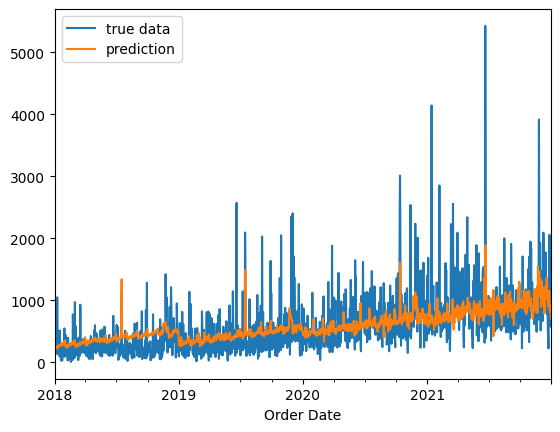

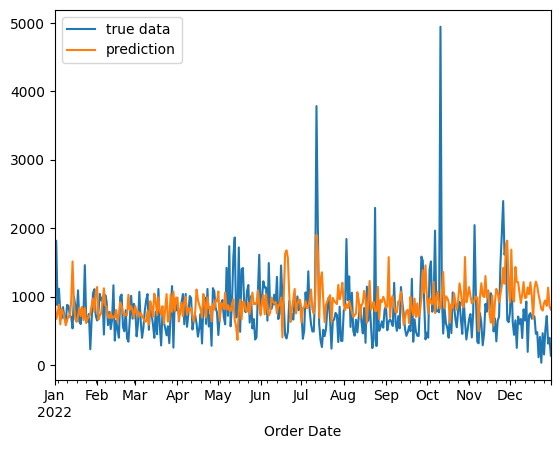

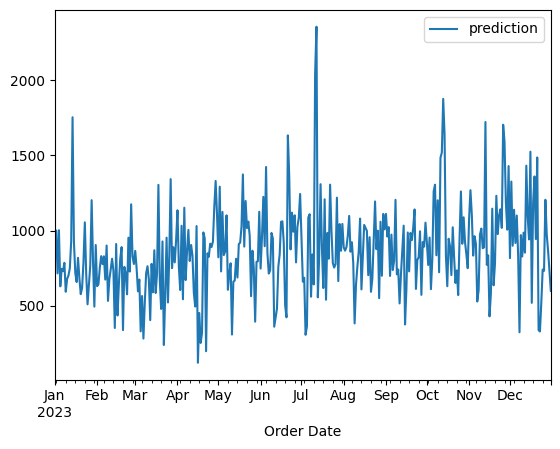

test:  486.67416618497634


In [54]:
preds, scores, feature_importances = cross_validate(ga_df, ga_forcast_df, feature_columns)

[0]	validation_0-rmse:491.82779	validation_1-rmse:735.12094
[1]	validation_0-rmse:470.00677	validation_1-rmse:713.52122
[2]	validation_0-rmse:450.47225	validation_1-rmse:695.35889
[3]	validation_0-rmse:433.05642	validation_1-rmse:679.97735
[4]	validation_0-rmse:417.54347	validation_1-rmse:666.48335
[5]	validation_0-rmse:403.81529	validation_1-rmse:654.96291
[6]	validation_0-rmse:391.65030	validation_1-rmse:644.81150
[7]	validation_0-rmse:380.87488	validation_1-rmse:635.74321
[8]	validation_0-rmse:371.35935	validation_1-rmse:627.58269
[9]	validation_0-rmse:362.96631	validation_1-rmse:620.20691
[10]	validation_0-rmse:355.58326	validation_1-rmse:613.43067
[11]	validation_0-rmse:349.06949	validation_1-rmse:607.15684
[12]	validation_0-rmse:343.33774	validation_1-rmse:601.28221
[13]	validation_0-rmse:338.28695	validation_1-rmse:595.72007
[14]	validation_0-rmse:333.83850	validation_1-rmse:590.45845
[15]	validation_0-rmse:329.90594	validation_1-rmse:585.41014
[16]	validation_0-rmse:326.42522	v

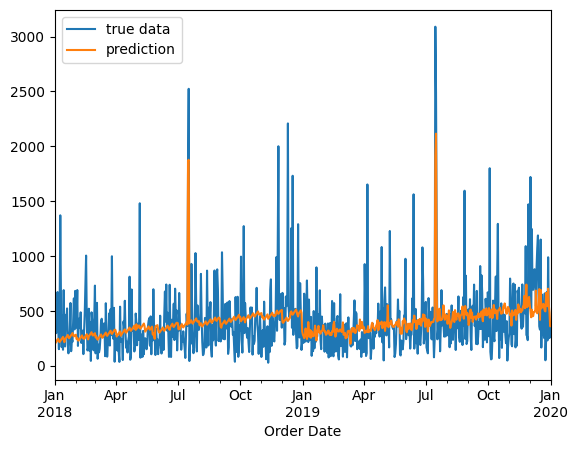

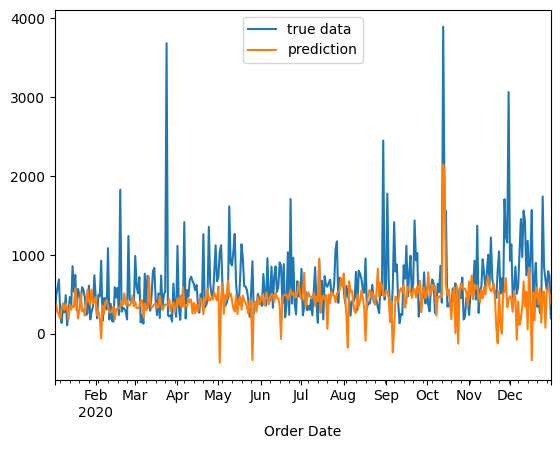

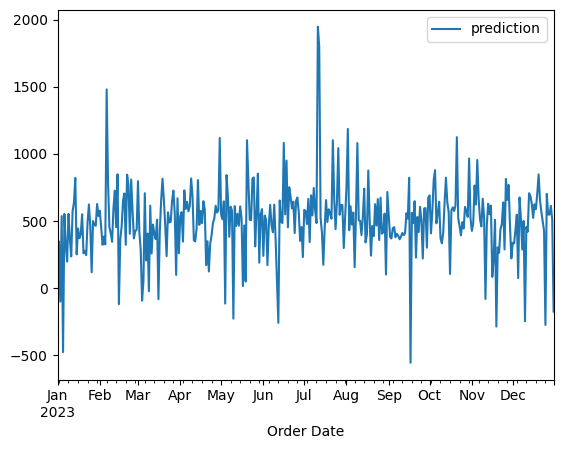

test:  488.21455369789936
[0]	validation_0-rmse:577.23054	validation_1-rmse:906.86892
[1]	validation_0-rmse:549.43071	validation_1-rmse:879.31711
[2]	validation_0-rmse:524.70873	validation_1-rmse:854.87648
[3]	validation_0-rmse:502.82534	validation_1-rmse:833.24859
[4]	validation_0-rmse:483.50092	validation_1-rmse:814.05156
[5]	validation_0-rmse:466.43776	validation_1-rmse:797.06455
[6]	validation_0-rmse:451.46280	validation_1-rmse:782.08390
[7]	validation_0-rmse:438.33008	validation_1-rmse:768.82460
[8]	validation_0-rmse:426.83181	validation_1-rmse:757.09817
[9]	validation_0-rmse:416.79830	validation_1-rmse:746.75657
[10]	validation_0-rmse:408.02765	validation_1-rmse:737.61131
[11]	validation_0-rmse:400.38444	validation_1-rmse:729.52845
[12]	validation_0-rmse:393.72447	validation_1-rmse:722.35640
[13]	validation_0-rmse:387.92112	validation_1-rmse:716.01007
[14]	validation_0-rmse:382.85174	validation_1-rmse:710.37159
[15]	validation_0-rmse:378.43633	validation_1-rmse:705.36889
[16]	val

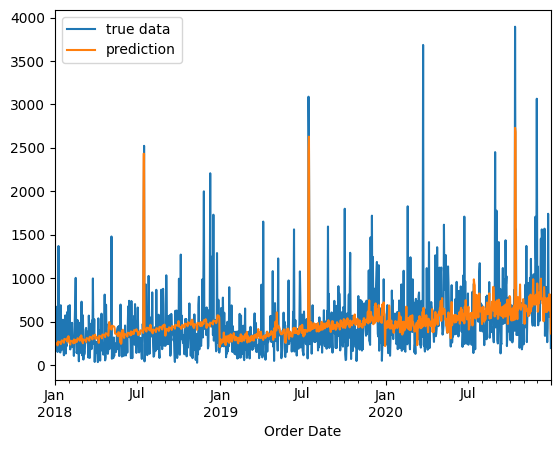

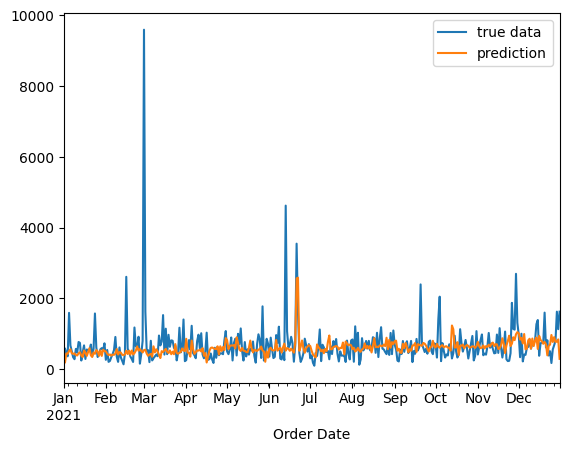

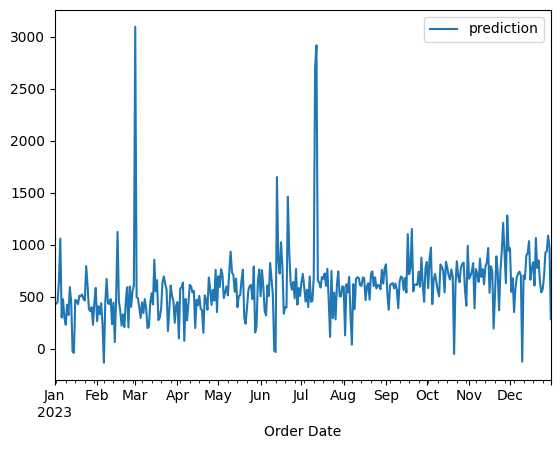

test:  648.2095734426691
[0]	validation_0-rmse:671.24404	validation_1-rmse:751.47919
[1]	validation_0-rmse:641.21528	validation_1-rmse:714.08118
[2]	validation_0-rmse:614.81171	validation_1-rmse:681.06271
[3]	validation_0-rmse:591.69543	validation_1-rmse:652.18056
[4]	validation_0-rmse:571.46392	validation_1-rmse:626.70117
[5]	validation_0-rmse:553.87575	validation_1-rmse:604.48387
[6]	validation_0-rmse:538.61471	validation_1-rmse:585.09348
[7]	validation_0-rmse:525.38324	validation_1-rmse:568.28007
[8]	validation_0-rmse:513.94272	validation_1-rmse:553.81758
[9]	validation_0-rmse:504.07781	validation_1-rmse:541.26739
[10]	validation_0-rmse:495.57788	validation_1-rmse:530.55065
[11]	validation_0-rmse:488.24668	validation_1-rmse:521.27630
[12]	validation_0-rmse:481.93690	validation_1-rmse:513.36662
[13]	validation_0-rmse:476.50860	validation_1-rmse:506.61053
[14]	validation_0-rmse:471.82707	validation_1-rmse:500.86343
[15]	validation_0-rmse:467.78397	validation_1-rmse:495.95592
[16]	vali

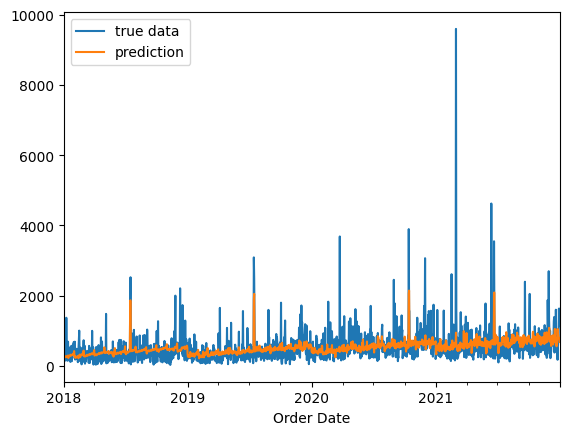

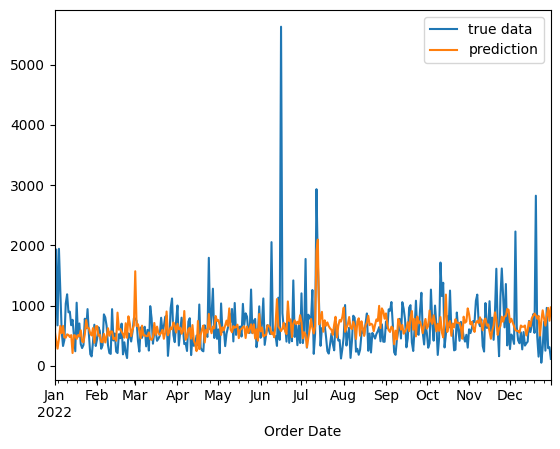

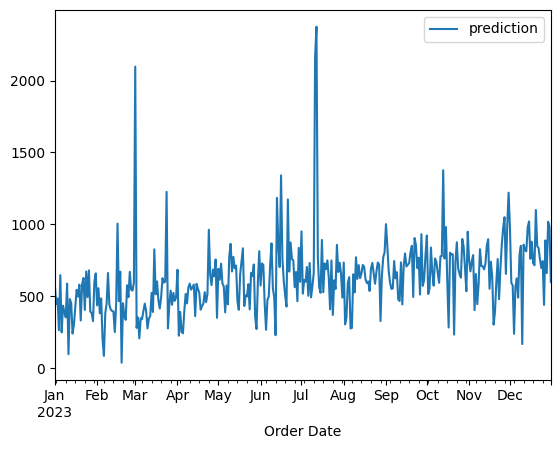

test:  467.187906056515


In [71]:
preds, scores, feature_importances = cross_validate(ma_df, ma_forcast_df, feature_columns)

[0]	validation_0-rmse:1623.29711	validation_1-rmse:2530.57467
[1]	validation_0-rmse:1522.54305	validation_1-rmse:2382.23889
[2]	validation_0-rmse:1432.08700	validation_1-rmse:2251.02175
[3]	validation_0-rmse:1351.09078	validation_1-rmse:2135.77870
[4]	validation_0-rmse:1278.76261	validation_1-rmse:2034.45002
[5]	validation_0-rmse:1214.29634	validation_1-rmse:1945.46304
[6]	validation_0-rmse:1156.98818	validation_1-rmse:1867.52739
[7]	validation_0-rmse:1106.43133	validation_1-rmse:1799.53373
[8]	validation_0-rmse:1061.72825	validation_1-rmse:1740.11249
[9]	validation_0-rmse:1022.46722	validation_1-rmse:1688.60806
[10]	validation_0-rmse:987.90472	validation_1-rmse:1643.53772
[11]	validation_0-rmse:957.72152	validation_1-rmse:1604.40523
[12]	validation_0-rmse:931.26185	validation_1-rmse:1570.44738
[13]	validation_0-rmse:908.26785	validation_1-rmse:1540.80476
[14]	validation_0-rmse:888.27125	validation_1-rmse:1515.01214
[15]	validation_0-rmse:870.84106	validation_1-rmse:1492.63732
[16]	val

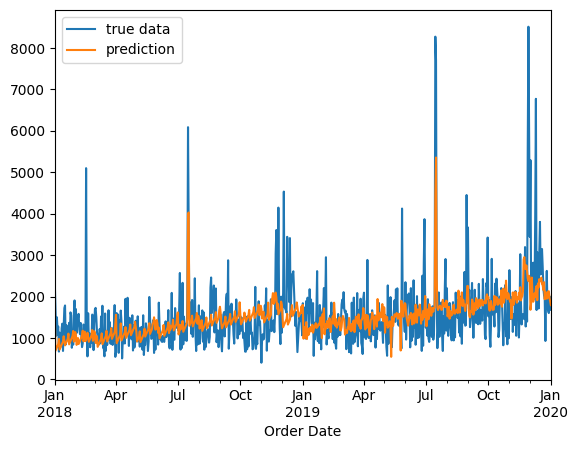

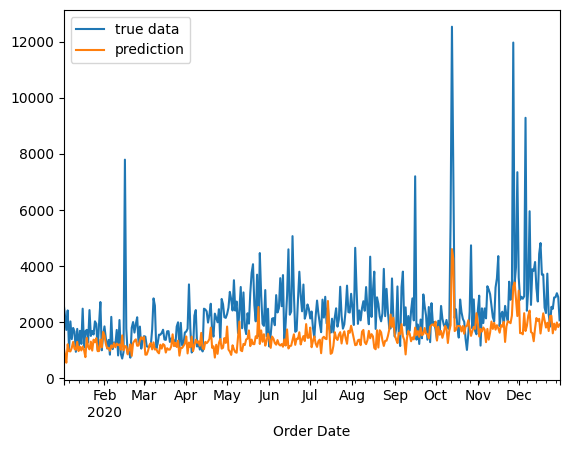

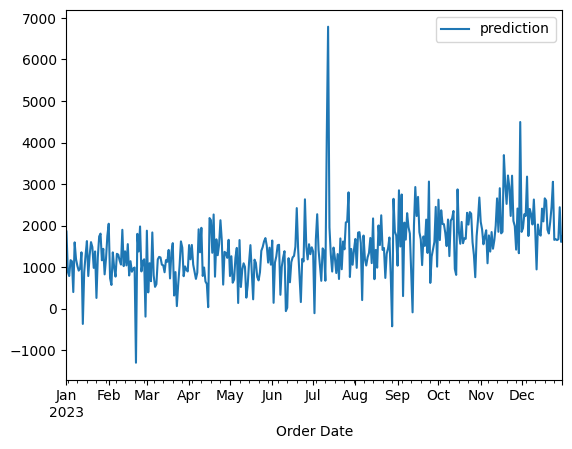

test:  1452.056867302618
[0]	validation_0-rmse:1954.89401	validation_1-rmse:2898.64310
[1]	validation_0-rmse:1821.06855	validation_1-rmse:2741.61141
[2]	validation_0-rmse:1701.97469	validation_1-rmse:2601.29127
[3]	validation_0-rmse:1596.93789	validation_1-rmse:2476.38172
[4]	validation_0-rmse:1504.62550	validation_1-rmse:2364.63725
[5]	validation_0-rmse:1423.62557	validation_1-rmse:2264.79338
[6]	validation_0-rmse:1352.92352	validation_1-rmse:2176.51019
[7]	validation_0-rmse:1291.43848	validation_1-rmse:2098.01853
[8]	validation_0-rmse:1238.08866	validation_1-rmse:2028.31137
[9]	validation_0-rmse:1192.11482	validation_1-rmse:1966.63198
[10]	validation_0-rmse:1152.50939	validation_1-rmse:1911.85535
[11]	validation_0-rmse:1118.46810	validation_1-rmse:1863.17035
[12]	validation_0-rmse:1089.37140	validation_1-rmse:1820.15290
[13]	validation_0-rmse:1064.49694	validation_1-rmse:1781.85356
[14]	validation_0-rmse:1043.15184	validation_1-rmse:1747.69704
[15]	validation_0-rmse:1024.91644	valida

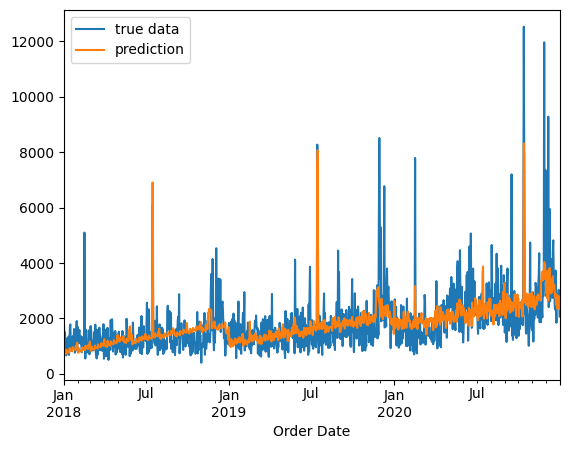

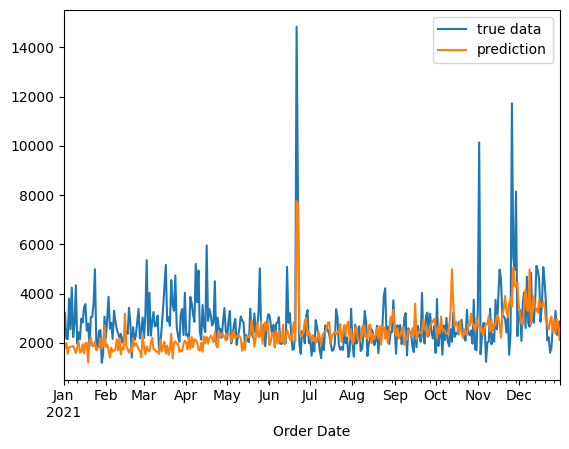

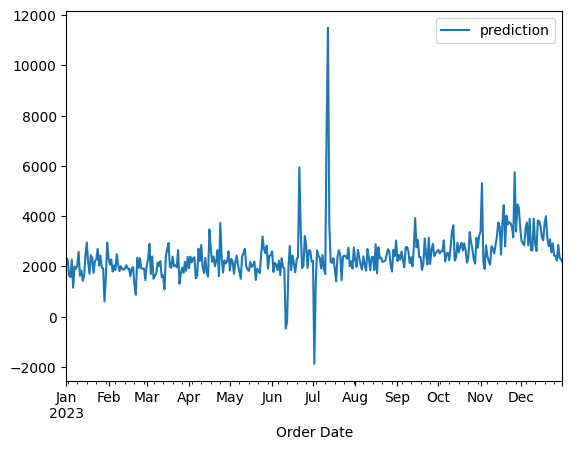

test:  1246.811324711071
[0]	validation_0-rmse:2204.94282	validation_1-rmse:2945.26659
[1]	validation_0-rmse:2046.70484	validation_1-rmse:2757.20370
[2]	validation_0-rmse:1907.09474	validation_1-rmse:2591.58824
[3]	validation_0-rmse:1784.49453	validation_1-rmse:2445.87248
[4]	validation_0-rmse:1677.31644	validation_1-rmse:2318.31809
[5]	validation_0-rmse:1583.75247	validation_1-rmse:2206.51694
[6]	validation_0-rmse:1502.26210	validation_1-rmse:2109.39348
[7]	validation_0-rmse:1431.97517	validation_1-rmse:2025.38861
[8]	validation_0-rmse:1371.59034	validation_1-rmse:1952.07427
[9]	validation_0-rmse:1319.73660	validation_1-rmse:1889.17471
[10]	validation_0-rmse:1275.45816	validation_1-rmse:1834.85122
[11]	validation_0-rmse:1237.68293	validation_1-rmse:1787.98916
[12]	validation_0-rmse:1205.58299	validation_1-rmse:1747.73676
[13]	validation_0-rmse:1178.30571	validation_1-rmse:1713.12309
[14]	validation_0-rmse:1155.17037	validation_1-rmse:1683.07339
[15]	validation_0-rmse:1135.52072	valida

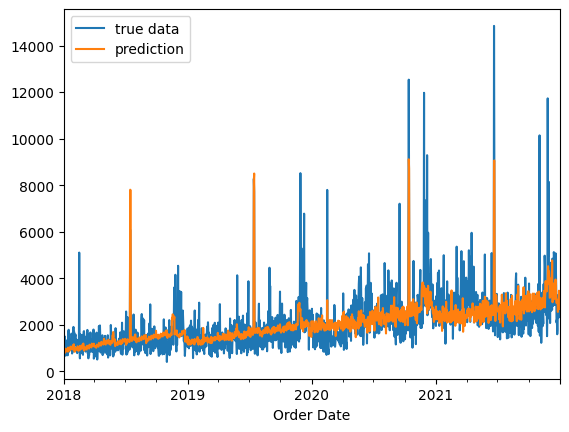

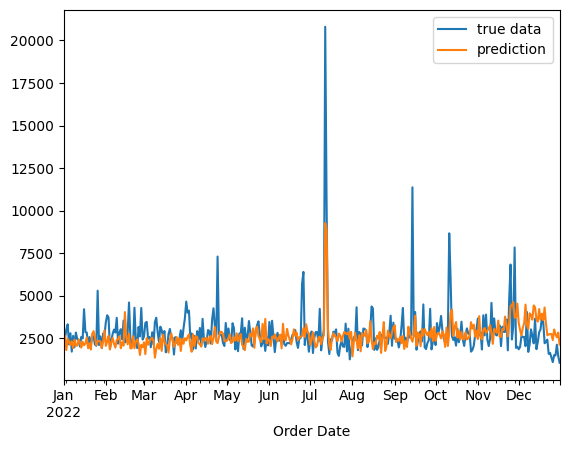

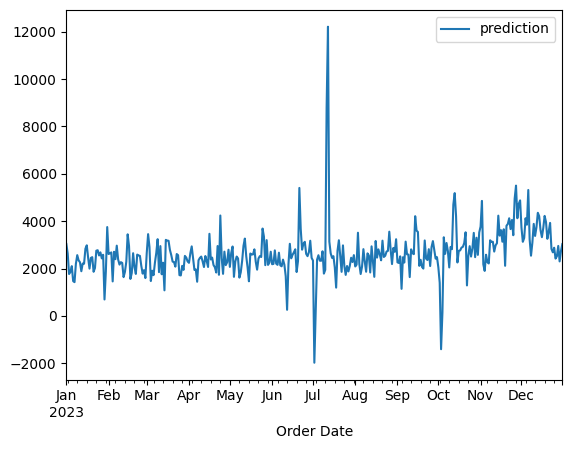

test:  1281.096876785278


In [72]:
preds, scores, feature_importances = cross_validate(ca_df, ca_forcast_df, feature_columns)

In [ ]:
feature_importances_df = pd.DataFrame([feature_columns, feature_importances[-1]*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

In [ ]:
int(np.sum(preds[0]))

## XGBOOST Train with full data

In [ ]:
# scores = []
# for i in range(1000):
#     reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=i, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
#     reg_model.fit(df[feature_columns], df['total_sales'], eval_set=[(df[feature_columns], df['total_sales'])], verbose=False)
#     y_preds = reg_model.predict(df[feature_columns])
#     scores.append(np.sqrt(mean_squared_error(df['total_sales'], y_preds)))
    

In [ ]:
plt.plot(range(1000),scores)

In [ ]:
scores[400:]

In [81]:
reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=400, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
reg_model.fit(ca_df[feature_columns], ca_df['total_sales'], eval_set=[(ca_df[feature_columns], ca_df['total_sales'])], verbose=False)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
feature_importances_df = pd.DataFrame([feature_columns, reg_model.feature_importances_*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

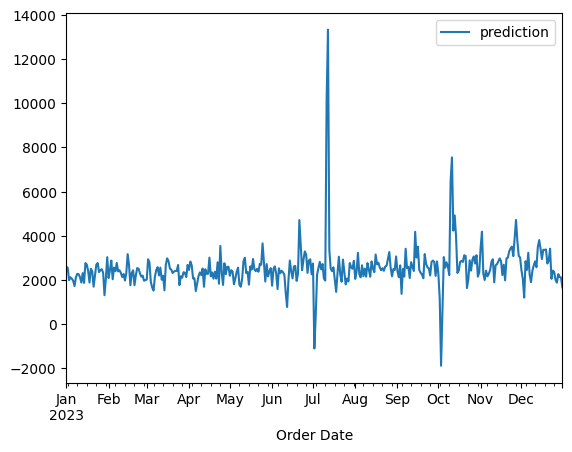

In [82]:
y_preds = reg_model.predict(ca_forcast_df[feature_columns])
ds =  pd.Series(y_preds, index=ca_forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

In [58]:
from catboost import CatBoostRegressor

In [ ]:
def cross_validate(df, forcastdf, feature_columns):
    feature_importances = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    param_grid = {'depth':[3], 'l2_leaf_reg':[1,2,3,5,10,12] ,'learning_rate':[0.01, 0.05],'n_estimators':[600, 800, 1000, 2000]}
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = GridSearchCV(CatBoostRegressor(silent=True), param_grid, scoring='neg_root_mean_squared_error')
        # reg_model = CatBoostRegressor(depth= 3, l2_leaf_reg= 2, learning_rate= 0.01, n_estimators= 800, silent=True)
        reg_model.fit(X_train, y_train,early_stopping_rounds=50)
        print(reg_model.best_params_)
        y_preds = reg_model.predict(X_train)
        score = np.sqrt(mean_squared_error(y_train, y_preds))
        print('training error: ',score)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        print('test error: ',score)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        preds.append(y_preds)

    return feature_importances

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 600}
training error:  259.308585511825


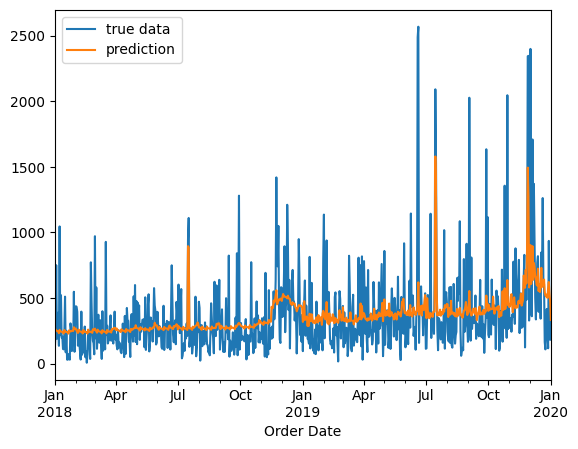

test error:  433.3841642081741


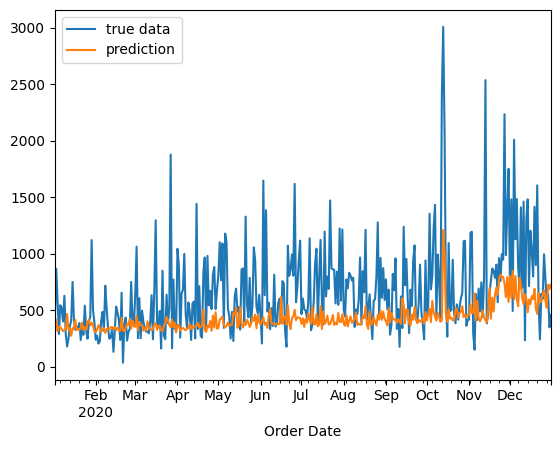

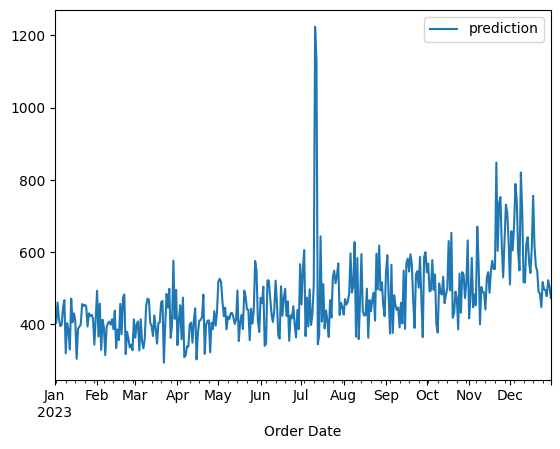

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 800}
training error:  280.169674705091


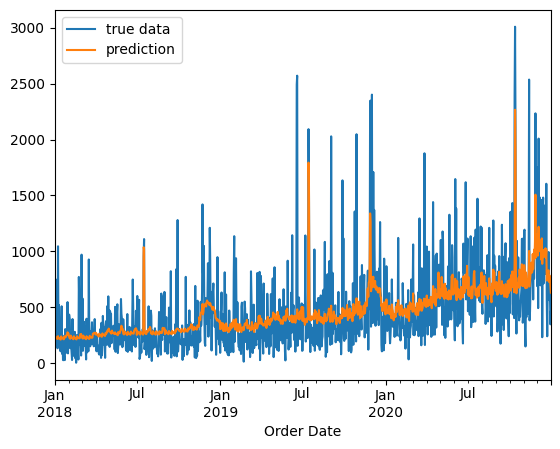

test error:  560.033978803783


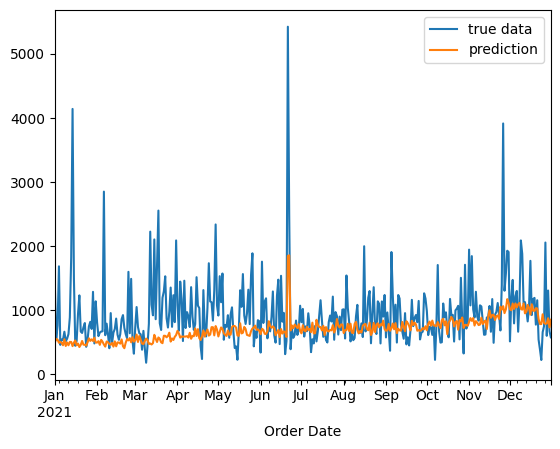

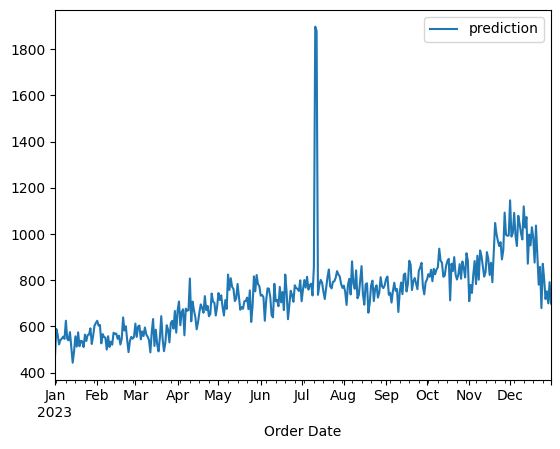

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 1000}
training error:  324.88860223341834


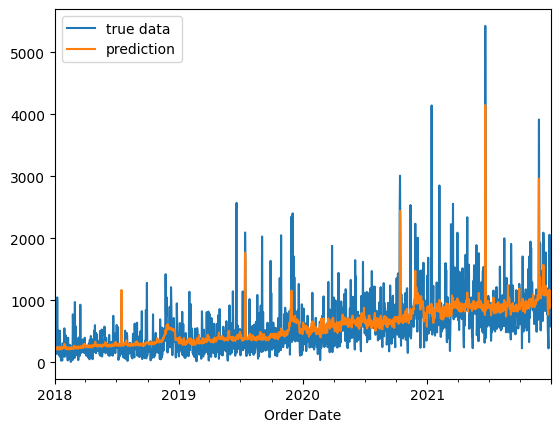

test error:  480.1767487308556


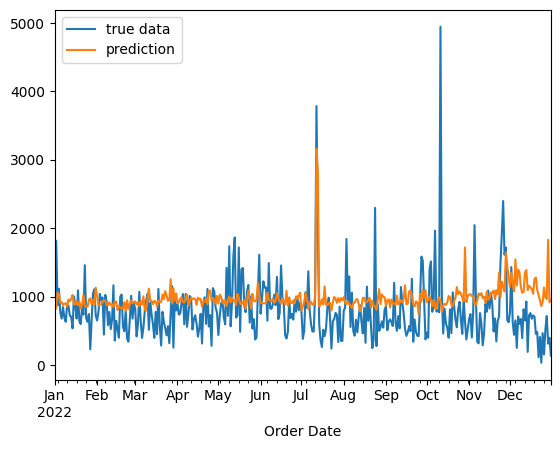

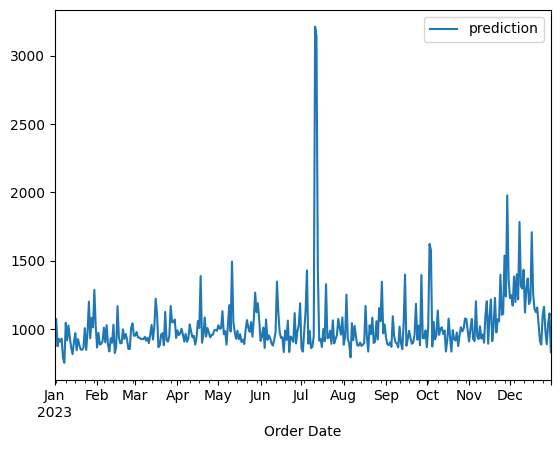

[]

In [60]:
cross_validate(ga_df, ga_forcast_df, feature_columns)

{'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.01, 'n_estimators': 1000}
training error:  553.9762018333471


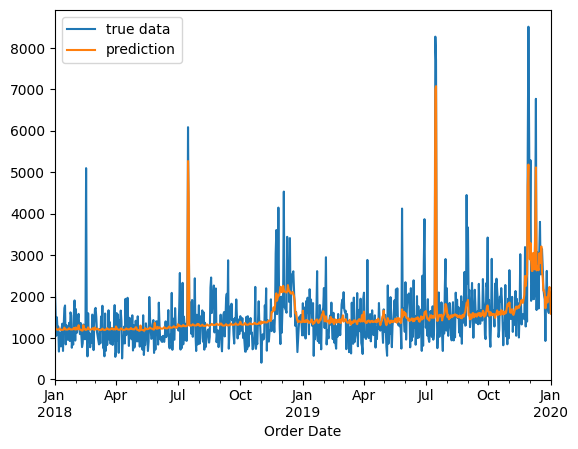

test error:  1268.171246681448


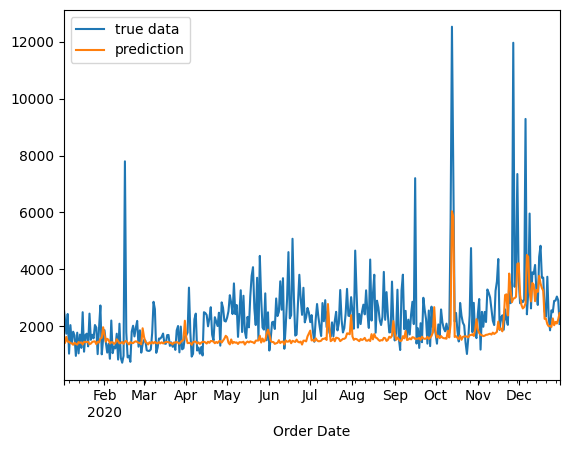

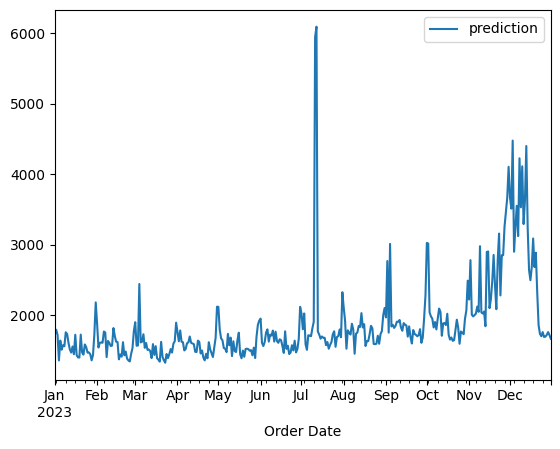

{'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'n_estimators': 800}
training error:  672.590716745415


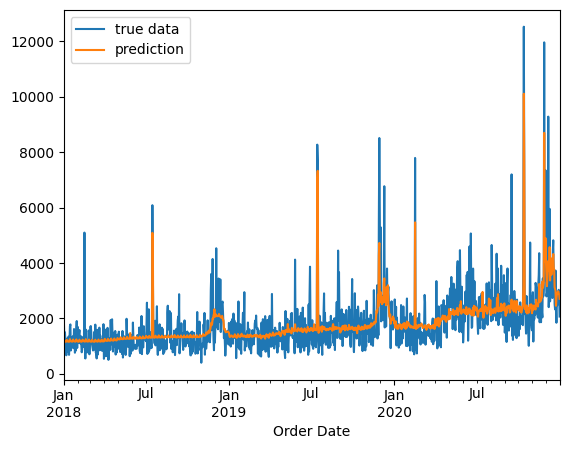

test error:  1256.8904692978206


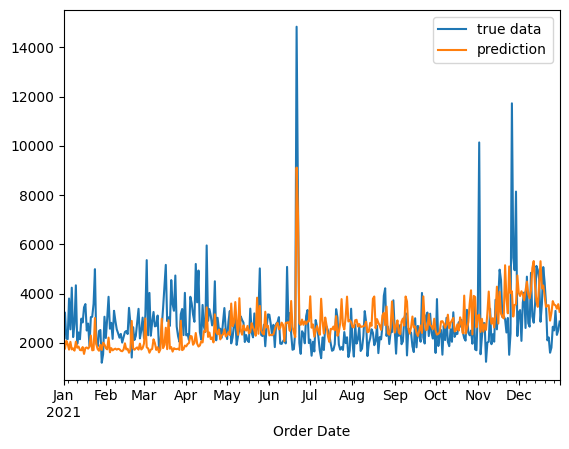

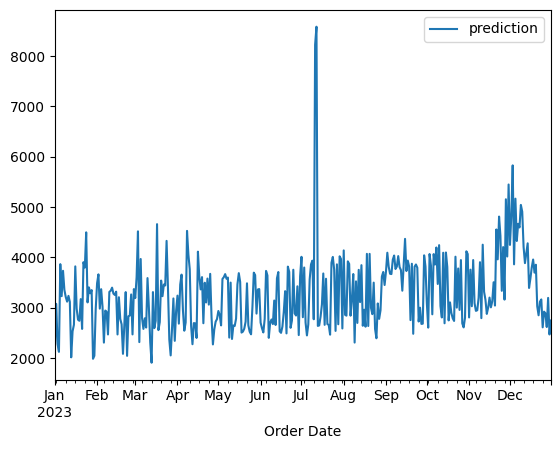

{'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.01, 'n_estimators': 2000}
training error:  675.5557168480408


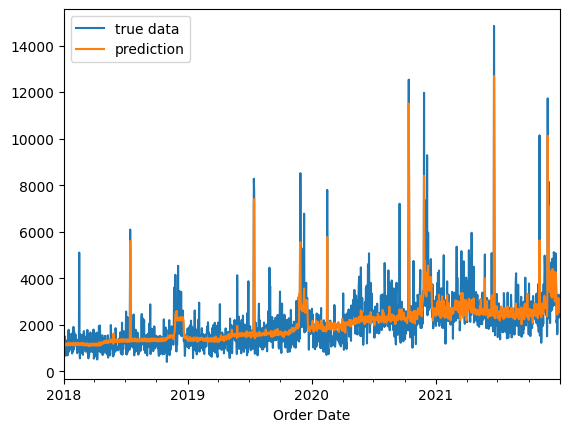

test error:  1385.3796318013983


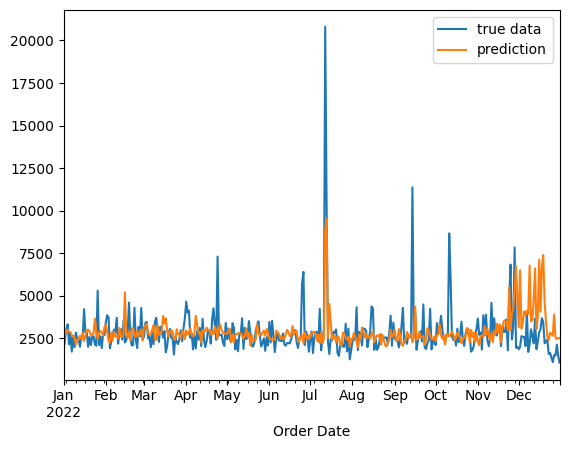

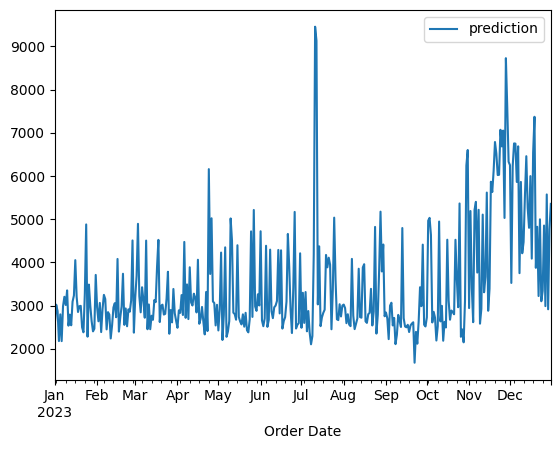

[]

In [75]:
cross_validate(ca_df, ca_forcast_df, feature_columns)

# Train Catboost with full data

In [66]:
reg_model = CatBoostRegressor(depth= 3, l2_leaf_reg= 2, learning_rate= 0.01, n_estimators= 1000, silent=True)
reg_model.fit(ga_df[sorted(feature_columns)], ga_df['total_sales'])

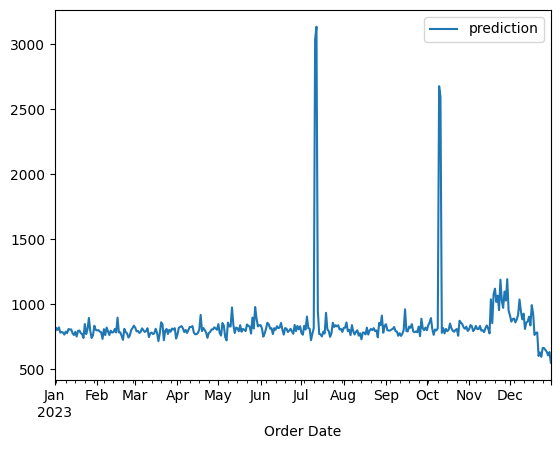

In [67]:
y_preds = reg_model.predict(ga_forcast_df[sorted(feature_columns)])
ds =  pd.Series(y_preds, index=ga_forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

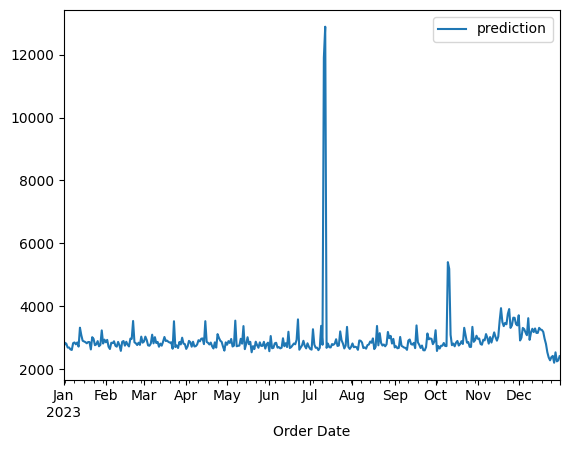

In [65]:
y_preds = reg_model.predict(ca_forcast_df[sorted(feature_columns)])
ds =  pd.Series(y_preds, index=ca_forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

In [ ]:
y_preds = reg_model.predict(df[sorted(feature_columns)])
ds =  pd.Series(y_preds, index=df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

In [76]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,PC3,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,...,-0.065581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,...,-0.007399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,...,-0.051748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,...,0.040292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,...,-0.060756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,...,-0.045194,0.089593,-0.079799,0.009743,0.037421,-0.122793,0.154869,0.002903,-0.046140,0.002251
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,...,-0.011386,0.147369,0.339498,0.092591,0.254677,0.272878,0.030991,-0.155592,-0.035450,0.062170
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,...,-0.021207,0.202109,0.172627,0.101446,0.209990,-0.080612,0.090700,-0.074762,-0.072250,0.007765


In [78]:
ga_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,PC3,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,120.85,1,1,2018,False,0,1,1,True,False,...,-0.018157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,223.69,2,1,2018,False,1,2,1,False,False,...,0.006835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,750.11,3,1,2018,False,2,3,1,False,False,...,0.029705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,188.71,4,1,2018,False,3,4,1,False,False,...,-0.017822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,296.01,5,1,2018,False,4,5,1,False,False,...,-0.003004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,522.93,27,12,2022,False,1,361,4,False,False,...,-0.116782,0.238116,0.290271,-0.222426,0.406425,-0.025805,0.495281,-0.185386,-0.003624,0.009075
2022-12-28,716.57,28,12,2022,False,2,362,4,False,False,...,0.343421,-0.090689,0.024119,-0.047783,0.156712,-0.241336,0.039213,-0.192653,0.015206,-0.001834
2022-12-29,313.63,29,12,2022,False,3,363,4,False,False,...,-0.000153,0.366527,-0.420375,-0.168931,0.024571,-0.116877,0.004540,0.388249,-0.310828,-0.281523


In [83]:
ca_forcast_df.columns

Index(['day', 'month', 'year', 'is_weekend', 'day_of_week', 'day_of_year',
       'quarter', 'is_month_start', 'is_month_end', 'is_year_start',
       'is_year_end', 'Amazon Events_Amazon Prime Day',
       'Amazon Events_Black Friday', 'Amazon Events_Memorial Day Sales',
       'Amazon Events_Mother's Day Deals', 'Amazon Events_No Events',
       'Amazon Events_Prime Big Deal Days',
       'Amazon Events_Valentine's Day Promotions',
       'Amazon Events_Year-End Clearance Sale', 'fedral_holiday', 'Sales 1YA',
       'Sales 2YA', 'Sales 3YA', 'PC1 1YA', 'PC2 1YA', 'PC3 1YA', 'PC1 2YA',
       'PC2 2YA', 'PC3 2YA', 'PC1 3YA', 'PC2 3YA', 'PC3 3YA'],
      dtype='object')

In [88]:
int(ca_forcast_df.index.year[-1] - ca_forcast_df.index.year[0])

0

In [90]:
ca_df[ca_df.index.year> (2021 - int(ca_forcast_df.index.year[-1] - ca_forcast_df.index.year[0]))]

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,PC3,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,1709.08,1,1,2022,False,5,1,1,True,False,...,0.190776,-0.014012,-0.023470,0.112346,0.205086,0.500018,-0.050419,-0.107456,-0.194052,0.144243
2022-01-02,2479.70,2,1,2022,True,6,2,1,False,False,...,0.106862,0.303867,0.207326,0.204177,-0.130381,-0.121676,0.022643,-0.291308,-0.029521,0.064429
2022-01-03,3012.94,3,1,2022,False,0,3,1,False,False,...,0.180663,0.015242,-0.096379,0.041934,-0.038593,-0.051083,-0.141494,-0.246329,-0.054445,-0.082541
2022-01-04,3316.56,4,1,2022,False,1,4,1,False,False,...,0.103549,-0.022533,0.020712,0.050922,-0.008707,0.317334,-0.126333,0.022478,0.258149,0.127757
2022-01-05,2137.36,5,1,2022,False,2,5,1,False,False,...,-0.081372,0.290708,0.141667,-0.066585,-0.257536,-0.041146,0.013322,-0.154807,-0.025880,0.031818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,...,-0.045194,0.089593,-0.079799,0.009743,0.037421,-0.122793,0.154869,0.002903,-0.046140,0.002251
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,...,-0.011386,0.147369,0.339498,0.092591,0.254677,0.272878,0.030991,-0.155592,-0.035450,0.062170
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,...,-0.021207,0.202109,0.172627,0.101446,0.209990,-0.080612,0.090700,-0.074762,-0.072250,0.007765


In [92]:
pd.to_datetime("2023-01-01").year

2023

In [93]:
ca_df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,PC3,PC1 1YA,PC2 1YA,PC3 1YA,PC1 2YA,PC2 2YA,PC3 2YA,PC1 3YA,PC2 3YA,PC3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2281.01,1,1,2018,False,0,1,1,True,False,...,-0.065581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,1710.42,2,1,2018,False,1,2,1,False,False,...,-0.007399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1053.32,3,1,2018,False,2,3,1,False,False,...,-0.051748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1501.36,4,1,2018,False,3,4,1,False,False,...,0.040292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1188.93,5,1,2018,False,4,5,1,False,False,...,-0.060756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1508.82,27,12,2022,False,1,361,4,False,False,...,-0.045194,0.089593,-0.079799,0.009743,0.037421,-0.122793,0.154869,0.002903,-0.046140,0.002251
2022-12-28,1484.50,28,12,2022,False,2,362,4,False,False,...,-0.011386,0.147369,0.339498,0.092591,0.254677,0.272878,0.030991,-0.155592,-0.035450,0.062170
2022-12-29,2122.56,29,12,2022,False,3,363,4,False,False,...,-0.021207,0.202109,0.172627,0.101446,0.209990,-0.080612,0.090700,-0.074762,-0.072250,0.007765
